# Simple FMCW Radar Simulator

## License

```
Simple FMCW radar signal simulator to calculate if signals based
on sensor parameters and visualization of parameter influences.
Copyright (C) 2023+  Timo Jaeschke (timo.jaeschke@2pi-labs.com)

This program is free software; you can redistribute it and/or
modify it under the terms of the GNU General Public License
as published by the Free Software Foundation; either version 2
of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program; if not, write to the Free Software
Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston, MA  02110-1301, USA.
```

### Python / Jupyter Notebook Implementation 
Import of necessary Python modules and settings:

In [9]:
%matplotlib inline

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import collections
import scipy.constants as const

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (14, 20),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

### Definition of FMCW Sensor & Target
Model a radar sensor and target based on the most relevant parameter:

In [11]:
## Simulation Model Definitions
# Structure Radar & Target Model as a Named Tuple Collection 
Radar_Model = collections.namedtuple('SensorConfig', 'name f_start f_stop f_if t_ramp')  
Target_Model = collections.namedtuple('TargetConfig', 'name distance velocity amplitude reflection_phase')
Processing_Config = collections.namedtuple('ProcConf', 'name nfft')

# Fill with example values 
Radar = Radar_Model(
    name='Radar0', 
    f_start = 126e9, 
    f_stop = 182e9, 
    f_if = 5e6, 
    t_ramp = 1e-3)

Target = Target_Model(
    name = 'Target0', 
    distance = 1, 
    velocity = 0, 
    amplitude = 1,
    reflection_phase = 0)

ProcConf = Processing_Config(
    name = 'ProcConf0', 
    nfft = 2**16)

print ('Radar Model 1:',Radar) 
print ('Target Model 1:',Target)  
print ('ProcConf 1:',ProcConf)  

Radar Model 1: SensorConfig(name='Radar0', f_start=126000000000.0, f_stop=182000000000.0, f_if=5000000.0, t_ramp=0.001)
Target Model 1: TargetConfig(name='Target0', distance=1, velocity=0, amplitude=1, reflection_phase=0)
ProcConf 1: ProcConf(name='ProcConf0', nfft=65536)


## Axes Calculation for Fast-Time - Sweep & Range Domain

In [12]:
# Calculate Fast-Time Axes based on Radar and Processing Configuration 
def calcAxes(Radar_Model, Processing_Config):
    Axes = collections.namedtuple('Axes', 'ft_sweep_samples ft_sweep_time_axis ft_sweep_freq_axis ft_range_samples ft_range_freq_axis ft_range_dist_axis')
    sweep_points = np.round(Radar_Model.f_if * Radar_Model.t_ramp)
    span = Radar_Model.f_stop - Radar_Model.f_start
    
    # Fast Time Sweep-Domain Axis Calculation
    Axes.ft_sweep_samples = np.arange(0, sweep_points)
    Axes.ft_sweep_time_axis = Axes.ft_sweep_samples * Radar_Model.t_ramp / sweep_points
    Axes.ft_sweep_freq_axis = Radar_Model.f_start + Axes.ft_sweep_samples * span / sweep_points

    # Fast Time Range-Domain Axis Calculation
    Axes.ft_range_samples = np.arange(0, Processing_Config.nfft // 2)
    Axes.ft_range_freq_axis = Axes.ft_range_samples * sweep_points / Radar_Model.t_ramp / Processing_Config.nfft
    Axes.ft_range_dist_axis = Axes.ft_range_samples * sweep_points / np.abs(span) / 2 * const.c / Processing_Config.nfft
    return Axes

In [13]:
# Test of Axes Generation 
Axes = calcAxes(Radar, ProcConf)
print ('Sweep-Axis-Samples:',Axes.ft_sweep_samples) 
print ('Sweep-Axis-Time:',Axes.ft_sweep_time_axis) 
print ('Sweep-Axis-Frequency:',Axes.ft_sweep_freq_axis) 
print ('Range-Axis-Samples:',Axes.ft_range_samples) 
print ('Range-Axis-Freqeuncy:',Axes.ft_range_freq_axis) 
print ('Range-Axis-Distance:',Axes.ft_range_dist_axis) 

Sweep-Axis-Samples: [0.000e+00 1.000e+00 2.000e+00 ... 4.997e+03 4.998e+03 4.999e+03]
Sweep-Axis-Time: [0.000e+00 2.000e-07 4.000e-07 ... 9.994e-04 9.996e-04 9.998e-04]
Sweep-Axis-Frequency: [1.260000e+11 1.260112e+11 1.260224e+11 ... 1.819664e+11 1.819776e+11
 1.819888e+11]
Range-Axis-Samples: [    0     1     2 ... 32765 32766 32767]
Range-Axis-Freqeuncy: [0.00000000e+00 7.62939453e+01 1.52587891e+02 ... 2.49977112e+06
 2.49984741e+06 2.49992371e+06]
Range-Axis-Distance: [0.00000000e+00 2.04217405e-04 4.08434811e-04 ... 6.69118329e+00
 6.69138750e+00 6.69159172e+00]


## IF Signal Calculation

In [14]:
# Calculate IF/Beat Signal based on Radar and Taget data and Axes 
def calcIF(Radar, Target, Axes):
    sweep_points = int(np.round(Radar.f_if * Radar.t_ramp))
    span = Radar.f_stop - Radar.f_start
    
    TargetDistance = np.ones(sweep_points) * Target.distance + Axes.ft_sweep_time_axis * Target.velocity
    #print(TargetDistance)
    # Calculate Time-Delay (Tau) over Time for Target
    TimeDelay = 2 * TargetDistance / const.c ;  # Tau - Time Delay
    print(TimeDelay)
    # Calculate resulting IF 
    Ampl = Target_Model.amplitude 
    TermA = 2 * pi * span / Radar.t_ramp * TimeDelay * Axes.ft_sweep_time_axis 
    TermB = 2 * pi * Radar.f_start * TimeDelay 
    TermC = pi * span / Radar.t_ramp * TimeDelay**2
    TermD = Target.reflection_phase/360*2*pi;
    #PN=Environment.Sim.EnablePN *gen_pn(size(Ampl,2),Sensor.ADC.fs,Sensor.Sim.PN_Level,Sensor.Sim.PN_FlickerCorner,Sensor.Sim.PN_Loopbandwidth); %Phase noise
    #RXN=Environment.Sim.EnableRXN * Sensor.Sim.RXN_Level*randn(size(Ampl,2),1)'; % Receiver Noise
    #IF = Ampl.*cos(TermA+TermB-TermC-TermD+PN)+RXN
    IF = Target.amplitude * np.cos(TermA+TermB-TermC-TermD)
    return IF

interactive(children=(FloatSlider(value=1.0, description='TargetDist', max=5.0, min=0.1), FloatSlider(value=0.…

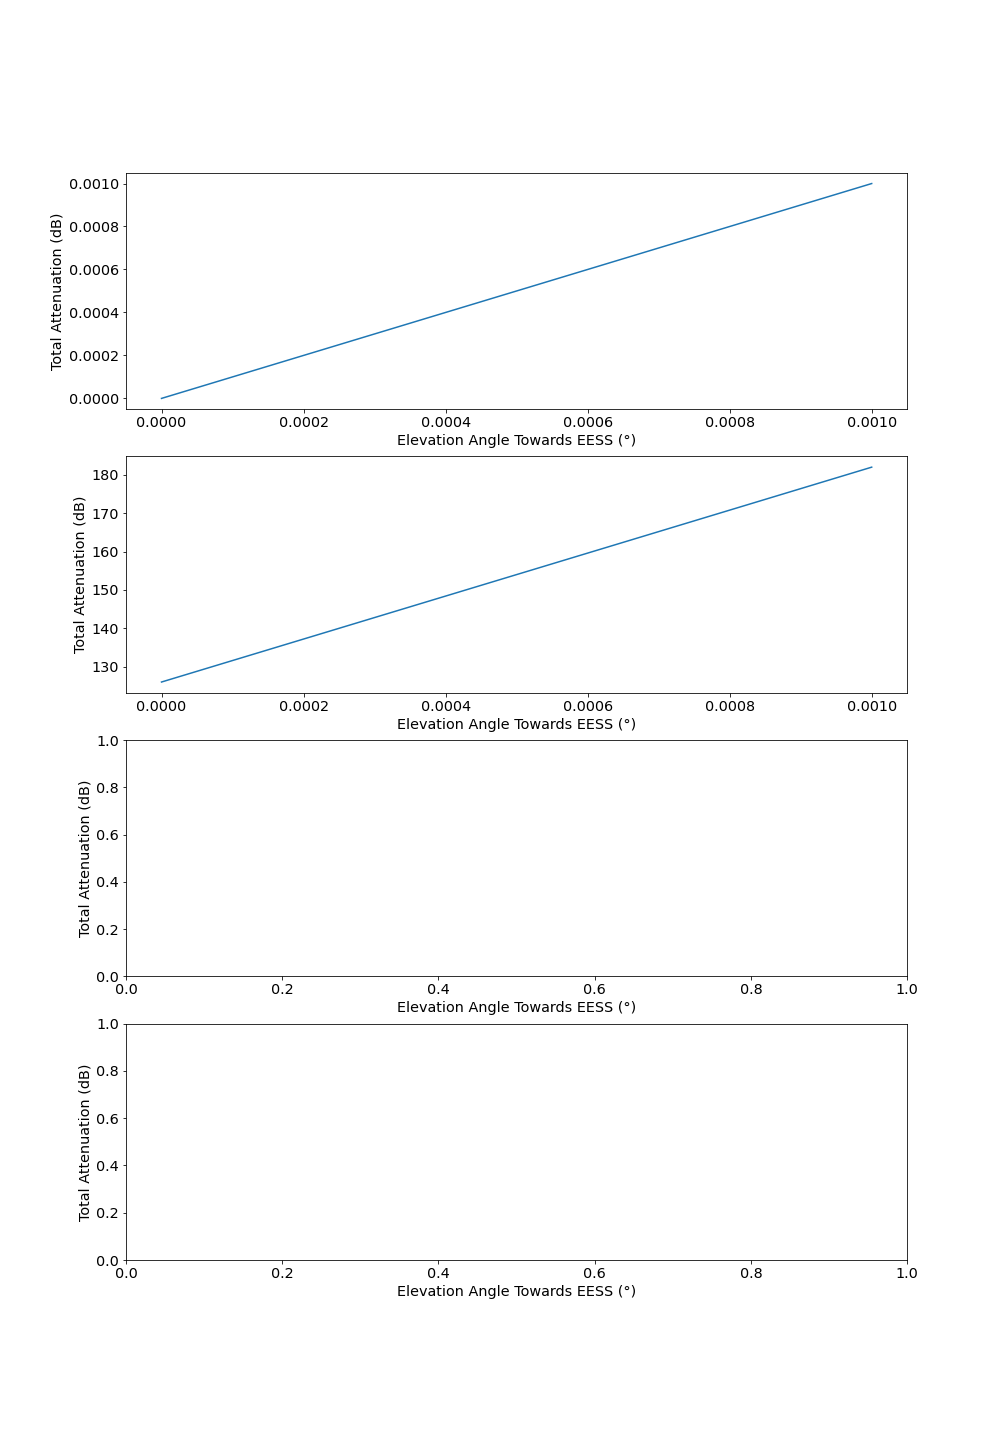

In [19]:
%matplotlib widget
import ipywidgets as interactive
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (14,20)
fig = plt.figure()
ax_time = fig.add_subplot(411)
ax_frequency = fig.add_subplot(412)
ax_IF = fig.add_subplot(413)
ax_RangeProfile = fig.add_subplot(414)

#ax.set_ylim(-1, 1)
#fig_time.grid()
ax_time.set_xlabel('Elevation Angle Towards EESS (°)') 
ax_time.set_ylabel('Total Attenuation (dB)')
ax_frequency.set_xlabel('Elevation Angle Towards EESS (°)') 
ax_frequency.set_ylabel('Total Attenuation (dB)')
ax_IF.set_xlabel('Elevation Angle Towards EESS (°)') 
ax_IF.set_ylabel('Total Attenuation (dB)')
ax_RangeProfile.set_xlabel('Elevation Angle Towards EESS (°)') 
ax_RangeProfile.set_ylabel('Total Attenuation (dB)')

def updateIF(Radar, Target, Axes, TargetDist):
    Target.distance=TargetDist
    updated_IF = calcIF(Radar, Target, Axes)
    return updated_IF


@interactive.interact(TargetDist=(0.1, 5, 0.1), phi=(0, 5, 0.1))
def update(TargetDist = Target.distance, phi = 0):
    [l.remove() for l in ax_frequency.lines]
    ax_time.plot(Axes.ft_sweep_time_axis, Axes.ft_sweep_time_axis, color='C0')
    ax_frequency.plot(Axes.ft_sweep_time_axis, Axes.ft_sweep_freq_axis/1e9, color='C0')
    ax_IF.plot(Axes.ft_sweep_time_axis, updateIF(Radar, Target, Axes), color='C0')

In [ ]:
class N(object):

    def __init__(self, ind, set, v):
        self.ind = ind
        self.set = set
        self.v = v

In [ ]:
%matplotlib widget
import ipywidgets as interactive
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_ylim(-1, 1)

t = np.linspace(0, 10, num = 1000)
    
def f(t, omega, phi):
    return np.sin(omega * t + phi)

@interactive.interact(omega=(0.1, 5, 0.1), phi=(0, 5, 0.1))
def update(omega = 1.0, phi = 0):
    [l.remove() for l in ax.lines]
    ax.plot(t, f(t, omega, phi), color='C0')

In [ ]:
%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

def f(omega, phi):
    plt.figure()
    t = np.linspace(0, 10, num = 5000)
    y = np.sin(omega * t + phi)
    plt.plot(t, y)
    plt.ylim(-1, 1)
    plt.show()

def f(omega, phi):
    plt.figure()
    t = np.linspace(0, 10, num = 5000)
    y = np.sin(omega * t + phi)
    plt.plot(t, y)
    plt.ylim(-1, 1)
    plt.show()

interactive_plot = interactive(f, omega=(0.1, 5, 0.1), phi=(0, 5, 0.1))

interactive_plot

interactive(children=(FloatSlider(value=1.0, description='omega', max=5.0, min=0.1), FloatSlider(value=0.0, de…

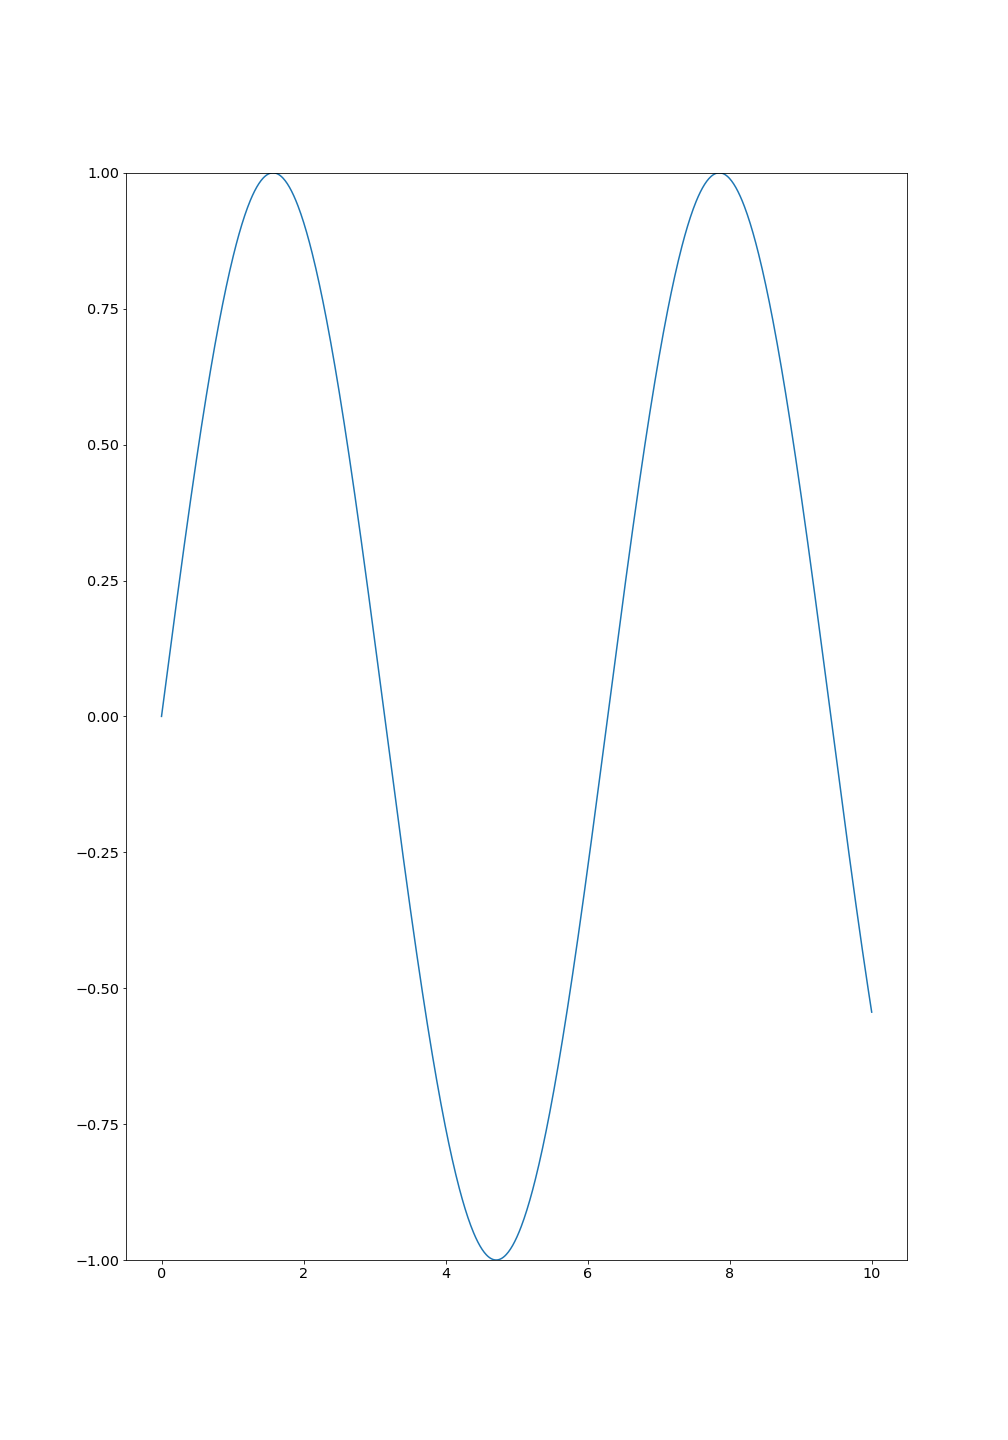

In [16]:
%matplotlib widget
import ipywidgets as interactive
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_ylim(-1, 1)

t = np.linspace(0, 10, num = 1000)
    
def f(t, omega, phi):
    return np.sin(omega * t + phi)

@interactive.interact(omega=(0.1, 5, 0.1), phi=(0, 5, 0.1))
def update(omega = 1.0, phi = 0):
    [l.remove() for l in ax.lines]
    ax.plot(t, f(t, omega, phi), color='C0')

In [ ]:
!pip install ipywidgets

In [ ]:
!conda install -c conda-forge ipympl

In [1]:
!jupyter labextension list

JupyterLab v3.3.2
C:\ProgramData\Anaconda3\share\jupyter\labextensions
        jupyter-matplotlib v0.11.2 enabled ok
        @jupyter-widgets/jupyterlab-manager v3.0.0 enabled ok (python, jupyterlab_widgets)

